In [1]:
%reload_ext lab_black

In [34]:
import control
import math
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from buck import F, plotTF

# Selecting Key Technical Specifications

We will design a 5V/5A (25W) buck converter using the Diodes Incorporated [AP64500](https://www.diodes.com/assets/Datasheets/AP64500.pdf), an integrated synchronous buck converter. This power converter is intended to be used as a generic power source with reasonably good performance characteristics (steady-state voltage ripple, load step transient voltage overshoot and recovery time).

Selecting the target ripple and transient response specifications depends on what is required by the load. Steady-state voltage ripple is a fundamental source of conducted noise. A load step transient response that is too large (or too long) may result in over/undervoltage at the downstream loads.

As a point of comparison, the [Keysight E36300](https://www.keysight.com/us/en/assets/7018-05629/data-sheets/5992-2124.pdf) is a popular generic mid-size switched-mode power supply capable of 2mVpp ripple and a 15mV settling band given a 5A load step (50us time to recover).

We will aim for something a bit more modest with 5mVpp ripple and a 30mV settling band given a 2.5A load step (50us time to recover). The target loop gain crossover frequency is generally recommended to be 1/10 the switching frequency to avoid significant interaction with the current-mode control sample-and-hold effect.

Digikey has plenty of "wall wart" AC/DC power supplies available that can be used as the input power source; something such as this [24V/36W supply](https://tensility.s3.amazonaws.com/uploads/pdffiles/16-00234.pdf) will be more than adequate.

In [3]:
vin_max = 24  # 24V input, max
vout = 5  # 5V output, fixed
iout_max = 5  # 5A output, max

fsw = 500e3  # 500kHz switching frequency, fixed
fc_target = fsw / 10  # 50kHz crossover frequency, target

iripple_target = 0.3 * 5  # 1.5A ripple current, target
vripple_target = 5e-3  # 5mV ripple voltage, target

istep = iout_max / 2  # 2.5A load step, typical
vstep_target = 30e-3  # 30mV load step voltage overshoot, target
tsettle_target = 50e-6  # 50us load step recovery time, target

# Designing for Steady-State Voltage Ripple
## Sizing the Inductor for Current Ripple

The buck converter datasheet recommends a ripple current between 30% to 50% of the maximum output current (5A). This is more of a guidance than a strict specification, many datasheets will allow for a ripple current as low as 10%, but it may not be recommended to stray far outside these bounds. The inductor current ripple may impact the internal design of the buck converter:
1. The boundary between continuous and discontinuous conduction mode, or in the case of the AP64500, the boundary between pulse width and pulse frequency modulation. Higher ripple current increases the load current at which the converter must transition to discontinuous conduction mode.
2. Power converter efficiency at various load levels. Higher inductance (and thus lower ripple current) reduces magnetic core losses but increases winding resistance losses at high load. Higher ripple current also increases the internal switch conduction losses.
3. The peak current limit detection threshold and the associated protection circuitry depend on the load current plus the ripple.
4. Larger ripple current requires more agressive slope compensation to eliminate sub-harmonic oscillation at duty cycles above 50%. Very small ripple current may affect the noise sensitivity of the cycle-by-cycle current limit detection.

We will select a standard inductance of 5.6uH for a resulting ripple current of 1.4A (28% of 5A). It is not uncommon for power inductors to have a tolerance of up to 20%, which would noticably impact the current and voltage ripple. We will select the 5.6uH shielded power inductor from [Bourns SRP1038C Series](https://www.bourns.com/docs/product-datasheets/srp1038c.pdf).

In [4]:
L_min = (vout / vin_max) * (vin_max - vout) / iripple_target / fsw
print("Minimum Inductance: {:0.1f} uH".format(L_min * 1e6))

Minimum Inductance: 5.3 uH


In [5]:
L = 5.6e-6  # 5.6uH (larger than minimum required)
iripple = (vout / vin_max) * (vin_max - vout) / (L * fsw)
print("Ripple Current: {:0.2f} A".format(iripple))

Ripple Current: 1.41 A


## Selecting Output Capacitance for Voltage Ripple

Low steady-state voltage ripple is achieved by selecting capacitors which minimize the output impedance at the switching frequency. These are usually smaller (high bandwidth) ceramic capacitors (low series resistance).

We will use ceramic capacitors from the [AVX X7R MLCC](https://datasheets.kyocera-avx.com/X7RDielectric.pdf) commercial series. Keep in mind that the effective capacitance changes as a function of voltage, temperature, and frequency. The final PCB layout will also impact the effective series inductance and resistance. We will select capacitor voltage ratings to be at least 4x the DC operating point (5V). Other component variations will be accounted for later when the overall loop gain is designed to have significant stability margin.

Plotted below are a few capacitor impedances. The datasheet unfortunately does not provide much detail on each capacitor's series resistance and self-resonant frequency. Instead we can use the [KEMET KSIM](https://ksim3.kemet.com/capacitor-simulation) tool to view a chart of a similar capacitor's impedance over frequency.

In [6]:
def cercap(c, esr, srf):
    # Return the ceramic capacitor impedance in the s-domain.
    #    c: capacitance (F)
    #    esr: series resistance (Ohm)
    #    srf: self-resonant frequency (Hz)
    esl = (1 / (srf * math.tau)) ** 2 / c
    return control.tf(1, [c, 0]) + control.tf([esl, 0], 1) + esr

In [7]:
cap1n = cercap(c=1e-9, esr=260e-3, srf=260e6)  # 0805, 1nF, 200V
cap10n = cercap(c=10e-9, esr=60e-3, srf=65e6)  # 0805, 10nF, 100V
cap100n = cercap(c=100e-9, esr=25e-3, srf=20e6)  # 0805, 100nF, 50V
cap1u = cercap(c=1e-6, esr=20e-3, srf=9e6)  # 0805, 1uF, 25V
cap10u = cercap(c=10e-6, esr=4e-3, srf=1.3e6)  # 1206, 10uF, 16V

In [8]:
# code omitted from blog post
cap2n2 = cercap(c=2.2e-9, esr=180e-3, srf=200e6)  # 0805, 2.2nF, 200V
cap47n = cercap(c=47e-9, esr=43e-3, srf=40e6)  # 0805, 47nF, 100V

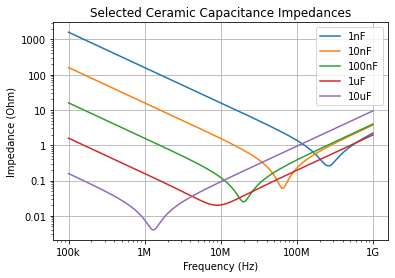

In [9]:
# code omitted from blog post
freq = np.logspace(5, 9, 1000)  # 100kHz to 1Ghz

z1n, _, _ = control.freqresp(cap1n, freq * math.tau)
z10n, _, _ = control.freqresp(cap10n, freq * math.tau)
z100n, _, _ = control.freqresp(cap100n, freq * math.tau)
z1u, _, _ = control.freqresp(cap1u, freq * math.tau)
z10u, _, _ = control.freqresp(cap10u, freq * math.tau)

plt.loglog(freq, z1n, label="1nF")
plt.loglog(freq, z10n, label="10nF")
plt.loglog(freq, z100n, label="100nF")
plt.loglog(freq, z1u, label="1uF")
plt.loglog(freq, z10u, label="10uF")
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel("Impedance (Ohm)")
plt.title("Selected Ceramic Capacitance Impedances")
plt.grid()
plt.xticks(ticks=[1e5, 1e6, 1e7, 1e8, 1e9], labels=["100k", "1M", "10M", "100M", "1G"])
plt.gca().yaxis.set_major_formatter(FormatStrFormatter("%g"))

It is worth including some small capacitors with high-resonant frequencies in order to sink any high-frequency noise due to the switching frequency harmonics. It is hard to say how much to include without performing a high-fidelity power integrity analysis (using a tool such as [HyperLynx](https://eda.sw.siemens.com/en-US/pcb/hyperlynx/)).

In total we will select our final ceramic capacitance to be the parallel combination of 10x 10uF, 4x 1uF, 6x 47nF, and 8x 2.2nF. The resulting impedance from 100kHz to 1GHz is plotted below with the red dot signifying the impedance at the switching frequency (500kHz). The resulting steady-state voltage ripple is 3.7mV.

In [10]:
def parz(*args):
    # Return the parallel impedance of all arguments in the s-domain.
    if len(args) == 1:
        return args[0]
    else:
        z1 = args[0]
        z2 = parz(*args[1:])
        zpar = z1 * z2 / (z1 + z2)
        return zpar.minreal()

In [11]:
final_cercap = parz(cap10u / 10, cap1u / 4, cap47n / 6, cap2n2 / 8)
zfinal_cercap, _, _ = control.freqresp(final_cercap, freq * math.tau)
zripple = np.interp(fsw, freq, zfinal_cercap)
vripple = iripple * zripple
print("Voltage Ripple: {:0.1f} mV".format(vripple * 1e3))

Voltage Ripple: 3.7 mV


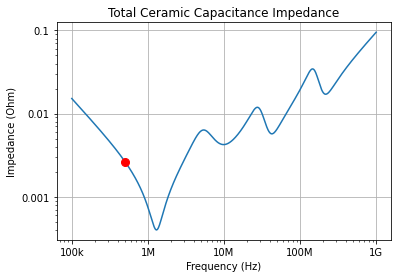

In [12]:
# code omitted from blog post
plt.loglog(freq, zfinal_cercap)
plt.plot(fsw, zripple, "ro", markersize=8)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Impedance (Ohm)")
plt.title("Total Ceramic Capacitance Impedance")
plt.grid()
plt.xticks(ticks=[1e5, 1e6, 1e7, 1e8, 1e9], labels=["100k", "1M", "10M", "100M", "1G"])
plt.gca().yaxis.set_major_formatter(FormatStrFormatter("%g"))

# Designing for Load Step Transient Response

## Fighting with the Datasheet

Designing a switched-mode power supply that is not only stable but has good load step transient response can be challenging. Unfortunately, my experience has been that regulator datasheets make the design process far more confusing than it needs to be. I have three primary complaints:

1. A current-mode control switched-mode regulator integrated circuit will feature an error amplifier and a PWM modulation gain stage. When assessing the converter loop gain, we need to know the transfer functions from the feedback voltage to the control voltage to the inductor current. This comes down to four key pieces of information: the feedback voltage, the error amplifier transconductance, the current sense gain, and the slope compensation. The first two are always displayed prominently in the specification table; the last two are always hidden somewhere in the application text (or in a diagram). As an alternative to the last two, the datasheet may instead provide a PWM modulation gain stage transconductance and leave you wondering about the bandwidth.
2. Different datasheets will give wildly different equations for how to select the bulk output capacitance and loop gain crossover frequency to achieve the desired load step transient response. Some equations are based on conservation of energy, others are empirical, and many are provided without any explanation whatsoever. They are all wrong! The transient overshoot and settling time depends on the loop gain of the system and therefore the bulk capacitance and compensation network must be designed in tandem. TI's application note on [load transient analysis](https://www.ti.com/lit/an/slua847/slua847.pdf) comes close by using calculus to achieve a closed-form solution but ultimately fails because...
3. Datasheet equations always assume a simple ouput capacitance composed of one capacitor type. Anything more complicated becomes an algebraic nightmare (even the application note linked above took the easy way out by assuming a Type-I compensation scheme). A real, optimized power converter will mix capacitors of different magnitudes and types. The resulting impedance is complex (pun intended) and understanding it is absolutely critical to achieving ideal performance.

## Bulk Capacitance

The amount of bulk capacitance required can be estimated by the load step current and the recovery time. Be mindful when selecting tantalum capacitors; manufacturers have a variety of series and case sizes that can result in series resistance ratings spanning an entire order of magnitude.

In [13]:
def tantcap(c, esr):
    return control.tf(1, [c, 0]) + esr

In [14]:
cap47u = tantcap(47e-6, 500e-3)  # AVX TAJC476K016RNJ
cap68u = tantcap(68e-6, 200e-3)  # AVX TPSC686K016R0200
cap100u = tantcap(100e-6, 125e-3)  # AVX TPSD107K016R0125
cap220u = tantcap(220e-6, 500e-3)  # KEMET T491X227K016AT

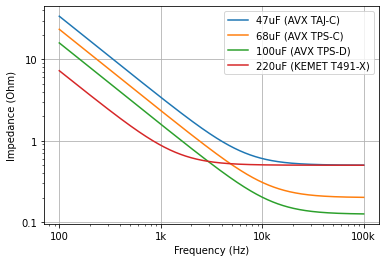

In [15]:
freq = np.logspace(2, 5, 1000)  # 100Hz to 100kHz

z47u, _, _ = control.freqresp(cap47u, freq * math.tau)
z68u, _, _ = control.freqresp(cap68u, freq * math.tau)
z100u, _, _ = control.freqresp(cap100u, freq * math.tau)
z220u, _, _ = control.freqresp(cap220u, freq * math.tau)

plt.loglog(freq, z47u, label="47uF (AVX TAJ-C)")
plt.loglog(freq, z68u, label="68uF (AVX TPS-C)")
plt.loglog(freq, z100u, label="100uF (AVX TPS-D)")
plt.loglog(freq, z220u, label="220uF (KEMET T491-X)")
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel("Impedance (Ohm)")
plt.grid()
plt.xticks(ticks=[100, 1e3, 1e4, 1e5], labels=["100", "1k", "10k", "100k"])
plt.gca().yaxis.set_major_formatter(FormatStrFormatter("%g"))

In [825]:
# Combine the tantalum bulk capacitance with ceramic capacitance, Zo(s).
Zo = parz(cap100u / 6, final_cercap)

## Switch-Mode Regulator Transfer Function

Ridley Engineering is the authority on the [small-signal model for current-mode control](https://ridleyengineering.com/images/current_mode_book/CurrentModeControl.pdf). The first step in designing the loop gain will be to derive the transfer function from the control voltage to the inductor current.

Without a current-mode control inner feedback loop, the transfer function is a voltage-controlled voltage source fed into the second-order filter created by the inductor resonating with the output capacitance (and load). The action of the current-mode control inner feedback loop is to turn the inductor into a voltage-controlled current source, thereby removing one pole.

In practice, the bandwidth of this transfer function is limited because the current-mode control inner feedback loop is a sampled-data system. The bandwidth becomes progressively more limited as the slope compensation is increased. Ridley has derived a very close approximation of the sample-and-hold effect that is valid up to half the switching frequency (250kHz). At the target loop gain crossover frequency (50kHz), this transfer function contributes about 60deg of phase.

In [1070]:
# Compute the control voltage to inductor current transfer function, F(s).
fsw = 500e3
Fexact = F(Vg=24, Vo=5, Ri=0.089, L=5.6e-6, Ts=1 / fsw, Se=1.87 * fsw)  # , Zo=Zo)

In [1071]:
# Define the feedback and compensation networks, Gfb(s) and Zea(s).
rtop, rbot = 43e3, 8.2e3
ztop = parz(rtop, cap1u + 1e3)
Gfb = rbot / (rbot + ztop)

gmea = 150e-6
rea = 68e3
chf = 10e-12
Zea = parz(rea + cap2n2, control.tf(1, [chf, 0]))

In [1072]:
# Compute the loop gain, T(s), and its stabiilty margin.
Texact = (Fexact * Zo * Gfb * gmea * Zea).minreal()

freq = np.logspace(np.log10(100), np.log10(fsw / 2), 1000)
mag, phase, omega = control.freqresp(Texact, freq * math.tau)
gm, pm, wpc, wgc = control.margin(mag, phase * 180 / np.pi, omega)
gmformat = "Gain  Margin: {:0.1f} dB  ({:3.0f} kHz phase crossover)"
pmformat = "Phase Margin: {:0.1f} deg ({:3.0f} kHz gain  crossover)"
print(gmformat.format(control.mag2db(gm), wpc / math.tau / 1e3))
print(pmformat.format(pm, wgc / math.tau / 1e3))

Gain  Margin: 17.1 dB  (151 kHz phase crossover)
Phase Margin: 71.6 deg ( 40 kHz gain  crossover)


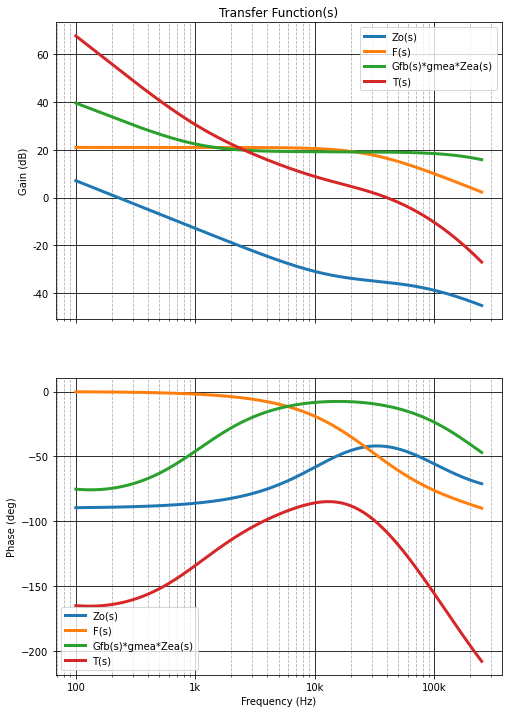

In [1073]:
plotTF(
    tf=[Zo, Fexact, Gfb * gmea * Zea, Texact],
    label=[
        "Zo(s)",
        "F(s)",
        "Gfb(s)*gmea*Zea(s)",
        "T(s)",
    ],
    flims=(100, fsw / 2),
    fticks=[1e2, 1e3, 1e4, 1e5],
    flabels=["100", "1k", "10k", "100k"],
)

In [1074]:
Yexact = (Zo / (Texact - 1)).minreal()

poles = Yexact.pole()
poles = poles[np.abs(poles) < fsw / 2]
# poles = poles[np.real(poles) < 0]
poles = np.hstack((poles, [-fsw / 2 * math.tau, -fsw / 2 * math.tau]))

zeros = Yexact.zero()
zeros = zeros[np.abs(zeros) < fsw / 2]

num, den = zpk2tf(zeros, poles, 1)
Yest = control.tf(num, den)
Yest = Yest  # * Yexact.dcgain() / Yest.dcgain()

(array([-1.17593946e+09+0.00000000e+00j, -4.25687342e+08+9.69100757e+08j,
        -4.25687342e+08-9.69100757e+08j, -6.09375249e+07+1.75351208e+08j,
        -6.09375249e+07-1.75351208e+08j, -1.27436617e+07+2.95104759e+07j,
        -1.27436617e+07-2.95104759e+07j, -1.33565313e+07+0.00000000e+00j,
        -1.12419480e+06+2.34031842e+05j, -1.12419480e+06-2.34031842e+05j,
         1.65965662e+05+0.00000000e+00j, -1.00422006e+05+0.00000000e+00j,
        -6.39744509e+03+0.00000000e+00j, -2.27272066e+01+0.00000000e+00j]),
 array([-3.12669067e+08+1.21711740e+09j, -3.12669067e+08-1.21711740e+09j,
        -6.38287056e+07+2.43087154e+08j, -6.38287056e+07-2.43087154e+08j,
        -3.19775183e+07+4.66389339e+07j, -3.19775183e+07-4.66389339e+07j,
        -1.33512447e+07+0.00000000e+00j, -1.33437052e+06+8.05841058e+06j,
        -1.33437052e+06-8.05841058e+06j, -1.47726883e+06+0.00000000e+00j,
        -1.84806822e+05+0.00000000e+00j, -8.00000000e+04+0.00000000e+00j,
        -1.26795122e+02+0.00000000e+

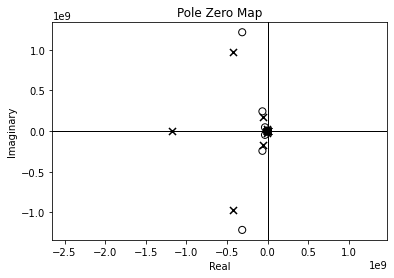

In [1075]:
control.pzmap(Yexact)

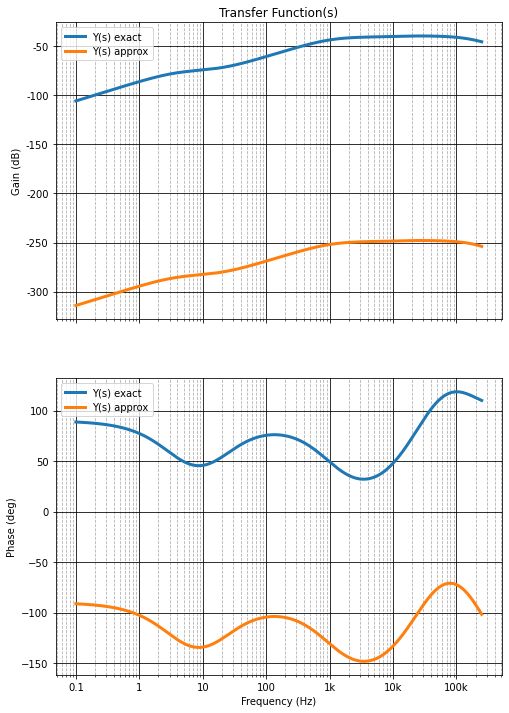

In [1076]:
plotTF(
    tf=[Yexact, Yest],
    label=["Y(s) exact", "Y(s) approx"],
    flims=(0.1, fsw / 2),
    fticks=[0.1, 1, 10, 100, 1e3, 1e4, 1e5],
    flabels=["0.1", "1", "10", "100", "1k", "10k", "100k"],
)

In [900]:
from scipy.signal import convolve
from scipy import fft

In [861]:
def step2(tf, T, U, n):
    t = np.linspace(0, 2 * T, 2 * n)
    u = U * np.ones(2 * n)
    u[t < T] = 0
    freq = np.fft.rfftfreq(2 * n, t[1])
    mag, phase, _ = control.freqresp(tf, freq * math.tau)
    tffr = mag * np.exp(phase * 1j)
    x = np.fft.irfft(tffr, 2 * n)
    y = convolve(u, x, mode="valid", method="direct")
    y = x
    return t, y, u

In [1029]:
def step(tf, T, U, n):
    # Define an n-point unit step U with duration T (two-sided).
    assert n % 2 == 0, "FFT for even-number of samples."
    t = np.linspace(0, 3 * T, 3 * n) - T
    u = U * np.ones(3 * n)
    u[t < 0] = 0
    u[T < t] = 0

    freq = fft.fftfreq(3 * n, t[1] - t[0])
    ufft = fft.fft(u)
    tf_fr = control.evalfr(tf, freq * math.tau * 1j)
    yfft = ufft * tf_fr

    #     plt.subplot(3, 1, 1)
    #     plt.plot(fft.fftshift(freq), fft.fftshift(control.mag2db(np.abs(ufft))))
    #     plt.xscale("symlog")

    #     plt.subplot(3, 1, 2)
    #     plt.plot(fft.fftshift(freq), fft.fftshift(control.mag2db(np.abs(tf_fr))))
    #     plt.xscale("symlog")

    #     plt.subplot(3, 1, 1)
    #     plt.plot(fft.fftshift(freq), fft.fftshift(control.mag2db(np.abs(yfft))))
    #     plt.xscale("symlog")

    y = np.real(fft.ifft(yfft))
    return t, y, u

(array([-1.57079638e+06, -1.57079628e+06, -1.00598836e+05, -6.45304859e+03,
        -2.27306189e+01]),
 array([-1.87678090e+05, -8.00000000e+04, -1.38087786e+03, -1.26795122e+02]))

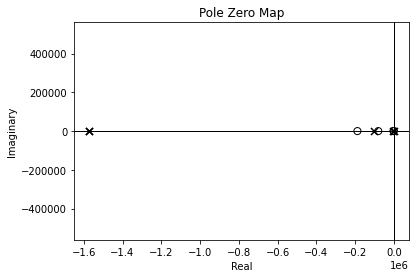

In [1047]:
control.pzmap(Yest)

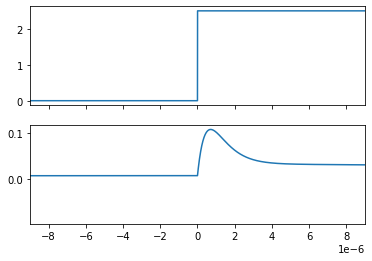

-0.08638552091211461


In [1049]:
T = 1e-3
t, y, u = step(Yest, T, U=2.5, n=int(1e6))
fig, (axu, axy) = plt.subplots(nrows=2, sharex=True)
axu.plot(t, u)
axy.plot(t, y)
plt.xlim((-9e-6, 9e-6))
plt.show()
print(min(y))

In [880]:
L = control.tf([0.1e-6, 0], 1)
R = 2
C = parz(control.tf(1, [1e-6, 0]), 1e6, L)
test = C / (R + C)

# Signal Injection Transformer

A true signal injection transformer with flat amplitude over a wideband is expensive (more expensive than it should be; it's just a big ferrite core packaged in a nice box). There are a number of blogs which discuss repurposing transformers intended for other applications as a cheaper alternative ([Maxim Integrated](https://www.maximintegrated.com/en/design/technical-documents/app-notes/3/3245.html), [Electronic Projects for Fun](https://electronicprojectsforfun.wordpress.com/injection-transformers/)).

The following image is from [Mini-Circuits application note AN20-001](https://www.minicircuits.com/app/AN20-001.pdf). It shows the lumped parasitic model of a transformer. The following analysis only considers the magnetizing inductance (Lp) and primary winding resistance (R1), as these are the only parasitic values provided on the [PE-51687NL](https://www.digikey.com/en/products/detail/pulse-electronics-power/PE-51687NL/2266077?s=N4IgTCBcDaIAoFEC0BWAjANgBwHYByAMiALoC%2BQA) datasheet.

<img src="images/transformer_parasitic_model.png">

Note that for this signal injection application, the current sense transformer will be used in the reverse direction. The datasheet's "secondary" will be our "primary".

In [22]:
Lp = 20e-3  # primary magnetizing inductance
R1 = 1.4  # primary winding resistance
n = 10 / 100  # 100-turn primary, 10-turn secondary
Rsrc = 25  #  primary drive, 50 Ohm series with 50 Ohm in shunt
Rload = 22  # secondary burden

In [23]:
tf_Lp = control.tf([Lp, 0], 1)  # s-domain, s * Lp
Rload_xfmr = Rload / n ** 2  # primary reflected burden
tf_Lp_Rload_xfmr = tf_Lp * Rload_xfmr / (tf_Lp + Rload_xfmr)  # tf_Lp // Rload_xfmr
xfmr_vp = tf_Lp_Rload_xfmr / (Rsrc + R1 + tf_Lp_Rload_xfmr)  # primary winding voltage
xfmr_vs = xfmr_vp * n  # secondary winding voltage

In [24]:
cutoff_frq = -control.pole(xfmr_vs)[1] / math.tau
dcgain = control.dcgain(xfmr_vs)
wbgain = np.abs(control.evalfr(xfmr_vs, 100 * cutoff_frq * math.tau))

print("DC Gain: {:0.2f} V/V".format(dcgain))
print("Wideband Gain: {:0.2f} V/V".format(wbgain))
print("Cutoff Frequency: {:0.0f} Hz".format(cutoff_frq))

DC Gain: 0.00 V/V
Wideband Gain: 0.10 V/V
Cutoff Frequency: 208 Hz


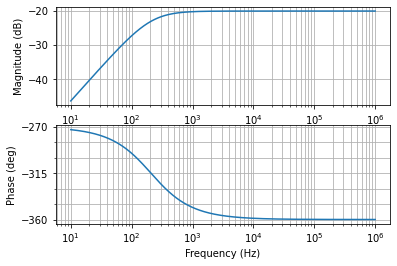

In [25]:
mag, phase, omega = control.bode_plot(xfmr_vs, omega_limits=(10, 1e6), Hz=True, dB=True)

In [26]:
vt_limit = 100 * 600e-6 / n  # volt-time product, bipolar
frq_limit = cutoff_frq / 100  # arbitrary
vt_gain = control.evalfr(xfmr_vp, frq_limit * math.tau) / frq_limit
vsrc_limit = np.abs(vt_limit / vt_gain / 2)  # square half-wave

print("Vsrc Limit (Volt-Time Product): {:0.1f} V".format(vsrc_limit))
# conclusion: transformer would overheat long before core saturation

Vsrc Limit (Volt-Time Product): 63.7 V
